# I2P k-Means-Algorithmus
Es wird ein k-Means-Algorithmus angwendet.

In [9]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP, Raw
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [10]:
source_ip = '10.8.0.2'
target_ip = '10.8.0.11'
packets = rdpcap('traffic_with_filter.pcap')

In [11]:
filter_with_source_ip = True


def filter_packets(packets):
    return [
        (frame_number, pkt) for frame_number, pkt in enumerate(packets, start=1)
        if IP in pkt
           and pkt[IP].dst == target_ip
           and (pkt[IP].src == source_ip if filter_with_source_ip else True)
    ]


filtered_packets = filter_packets(packets)

print(
    f"Anzahl der Pakete zu {target_ip}{' und von ' + source_ip if 'source_ip' in globals() and source_ip else ''}: {len(filtered_packets)}")

Anzahl der Pakete zu 10.8.0.11 und von 10.8.0.2: 435


# Features
Werden gelesen und für k-Means vorbereitet.

In [12]:
def byte_histogram(payload: bytes):
    counts = Counter(payload)
    hist = np.array([counts.get(i, 0) for i in range(256)])
    return hist / hist.sum() if hist.sum() > 0 else np.zeros(256)


def calc_entropy(payload: bytes):
    if not payload:
        return 0.0
    counts = Counter(payload)
    probs = np.array(list(counts.values())) / len(payload)
    return entropy(probs, base=2)


features = []
frame_numbers = []


def build_with_protocol():
    for frame_number, pkt in filtered_packets:
        if Raw in pkt:
            payload = bytes(pkt[Raw].load)
        if TCP in pkt:
            protocol = "tcp"
            src_port = pkt[TCP].sport
            dst_port = pkt[TCP].dport
        elif UDP in pkt:
            protocol = "udp"
            src_port = pkt[UDP].sport
            dst_port = pkt[UDP].dport
        else:
            protocol = "unknown"
            src_port = 0
            dst_port = 0

        payload_len = len(payload)
        hist = byte_histogram(payload)
        protocol_encoded = 0 if protocol == "tcp" else (1 if protocol == "udp" else 2)
        vec = [src_port, dst_port, payload_len, protocol_encoded, *hist]
        frame_numbers.append(frame_number)
        features.append(vec)

In [13]:
def create_feature_columns():
    df = pd.DataFrame(features)
    df.columns = ['src_port', 'dst_port', 'payload_len', 'protocol'] + [f'byte_{i}' for i in range(256)]
    df.head()
    scaler = StandardScaler()
    return scaler.fit_transform(df)

In [14]:
build_with_protocol()
X_scaled = create_feature_columns()

# Elbow-Auswertung

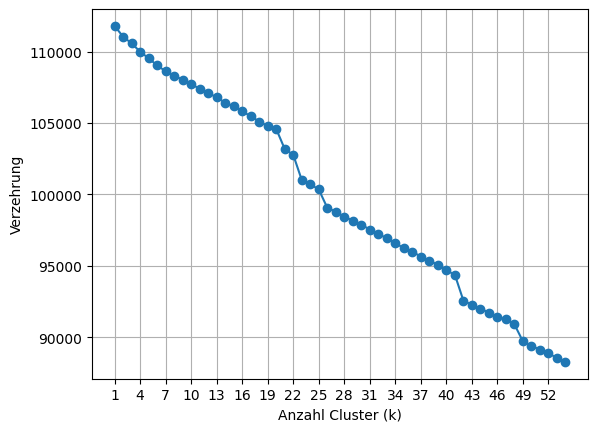

In [15]:
inertia = []
k_range = range(1, 55)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title("")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Verzehrung")
plt.grid(True)
plt.xticks(range(1, 55, 3))
plt.show()

# Anzahl Punkte pro Cluster zählen

In [17]:
from sklearn.cluster import KMeans

optimal_k = 49
km_optimal = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = km_optimal.fit_predict(X_scaled)

# Cluster sammeln
cluster_dict = {}
for index, label in enumerate(cluster_labels):
    cluster_dict.setdefault(label, []).append(index)

# Nach Grösse sortieren
sorted_clusters = sorted(cluster_dict.items(), key=lambda item: len(item[1]), reverse=True)

# Ausgabe: Cluster mit Frame-Nummern
for cluster, indices in sorted_clusters:
    frame_ids = [frame_numbers[i] for i in indices]
    print(f"Cluster {cluster} ({len(indices)} Punkte): Frames {frame_ids}\n")

# Durchschnitt
total_points = sum(len(indices) for _, indices in sorted_clusters)
average_points = total_points / optimal_k
print(f"⟶ Durchschnittliche Anzahl an Punkten pro Cluster: {average_points:.2f}\n")

# Clustergrössen zusammenfassen
cluster_size_counts = {}
for indices in cluster_dict.values():
    size = len(indices)
    cluster_size_counts[size] = cluster_size_counts.get(size, 0) + 1

print("Verteilung der Clustergrössen:")
for size in sorted(cluster_size_counts):
    count = cluster_size_counts[size]
    print(f"{size} Datenpunkte: {count} Cluster")


Cluster 46 (34 Punkte): Frames [1043, 1396, 1505, 4032, 4536, 7640, 8185, 8600, 9974, 10111, 12150, 12669, 12769, 13544, 13805, 15309, 16197, 16933, 17713, 19712, 20532, 20817, 24805, 24820, 25431, 26713, 26808, 27456, 32320, 34312, 35809, 37722, 38992, 40263]

Cluster 20 (27 Punkte): Frames [1895, 2935, 3097, 3199, 4575, 5389, 7495, 11303, 11903, 12019, 13791, 13908, 17229, 19346, 19725, 20120, 20996, 21348, 21490, 22002, 23084, 27869, 29473, 30737, 31604, 39221, 40207]

Cluster 43 (24 Punkte): Frames [1472, 5191, 5339, 5525, 5733, 5849, 9652, 9878, 12797, 15248, 15814, 22783, 23887, 24256, 24968, 25070, 25418, 26965, 32686, 33885, 38154, 38533, 40359, 41836]

Cluster 30 (19 Punkte): Frames [2593, 6862, 7314, 11220, 13271, 15472, 16494, 18800, 18885, 23408, 26432, 27017, 28007, 28522, 30105, 30632, 35842, 36974, 41562]

Cluster 27 (19 Punkte): Frames [5147, 7240, 7787, 8773, 9133, 10355, 10904, 15092, 19978, 21414, 23925, 30599, 32093, 32646, 32713, 33484, 37147, 39797, 39820]

Cluste